In [68]:
import numpy as np
import numpy.random as npr
from scipy import sparse
from scipy.spatial.distance import cosine
from time import time

from matplotlib import pyplot as plt
from matplotlib import animation, rc, collections
from IPython.display import HTML

**Storage in the network model**

In [43]:
def get_one(n):
    """Return array of ones of length n."""
    return np.ones(n)

def get_weights_rand(shape, prob):
    """Return a weights matrix with prob amount of random connections activated.
    
    Args:
        shape: (int) number of neurons in network
        prob: (float) fraction of connections to be activated
    
    Returns:
        weights: (numpy matrix) connectivity weight matrix
    """
    # THIS IS NOT QUITE RANDOM...
    l = int(shape*shape*prob)
    rows = npr.choice(range(shape), l)
    cols = npr.choice(range(shape), l)
    weights = sparse.csr_matrix((np.ones(l), (rows, cols)), shape=(shape,shape))
    weights.setdiag(0)
    return weights

def get_patterns(activity, num_neurons, num_patterns):
    """Return a matrix where each row is a pattern with activity level activity.
    
    Args:
        activity: (float) avg activity level per pattern
        num_neurons: (int) num neurons in network
        num_patterns: (int) num patterns to generate
    
    Returns:
        patterns: (numpy matrix) set of patterns shape=(num_patterns, num_neurons)
    """
#     l = int(num_neurons*activity)
#     rows = npr.choice(range(num_patterns), l)
#     cols = npr.choice(range(num_neurons), l)
#     patterns = sparse.csr_matrix((np.ones(l), (rows, cols)), shape=(num_patterns, num_neurons))
    return npr.binomial(1, activity, size=(num_patterns, num_neurons))

def get_syn_weights(patterns):
    """Return synaptic weight matrix.
    
    Args:
        patterns: (numpy matrix) set of patterns, shape=(num_patterns, num_neurons)
        
    Returns:
        syn: (numpy matrix) synaptic weight matrix, shape=(num_neurons, num_neurons)
    """
    num_patterns, num_neurons = patterns.shape
    row_ind = []
    col_ind = []
    for i in range(num_patterns):
        p = sparse.csr_matrix(patterns[i, :])
        mat = p.multiply(p.T)
        rows, cols = np.nonzero(mat)
        row_ind = np.concatenate([row_ind, rows])
        col_ind = np.concatenate([col_ind, cols])
    o = np.ones(len(row_ind))
    return sparse.csr_matrix((o, (row_ind, col_ind)), shape=(num_neurons, num_neurons))

# everything is decreased by 1 order of magnitude from paper

n = 30000                  # number of neurons in network; CA3 is 330,000 (or double)
p = .06                   # connection probability for weight matrix
m = 5                   # number of patterns to store
f = 0.001                  # average activity level of each pattern

now = time()
W = get_weights_rand(n, p) # connectivity weight matrix; are neurons connected?
print('made W in', time() - now)
now = time()
M = get_patterns(f, n, m)  # patterns
print('made M in', time() - now)
now = time()
J = get_syn_weights(M)     # synaptic weight matrix J; how much are neurons connected?
print('made J in', time() - now)
now = time()

W.shape, M.shape, J.shape

/anaconda3/lib/python3.6/site-packages/scipy/sparse/compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


made W in 11.856942892074585
made M in 0.002359151840209961
made J in 0.009465217590332031


((30000, 30000), (5, 30000), (30000, 30000))

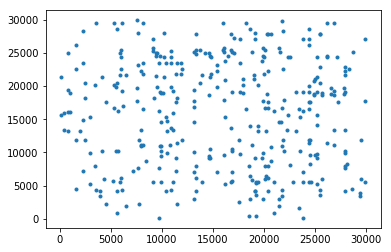

<Figure size 432x288 with 0 Axes>

In [44]:
def show_mat(mat):
    """Plot sparse matrix as scatter."""
    rows, cols = mat.nonzero()
    plt.scatter(rows, cols, marker='.')
    plt.show()
    plt.clf()
    
    
show_mat(W.multiply(J))

num connections: 24
num nodes: 1


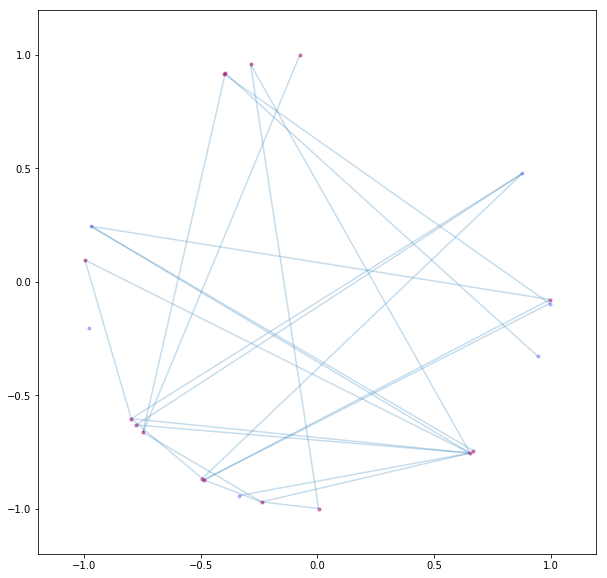

<Figure size 432x288 with 0 Axes>

In [75]:
def show_mat(pattern, source_mat):
    """Plot source_mat.multiply(pattern)  as circle w connector lines and pattern as the dots."""
    mat = source_mat.multiply(pattern)
    out = source_mat.dot(pattern)
    
    rows, cols = mat.nonzero()
    all_num = np.unique(rows+cols)
    print('num connections:', len(all_num))
    print('num nodes:', len(pattern.nonzero()))
    
    lines = [[(np.cos(r),np.sin(r)), (np.cos(c),np.sin(c))] for r, c in zip(rows, cols)]
    lc = collections.LineCollection(lines, alpha=0.25)
    fig, ax = plt.subplots()
    fig.set_size_inches(10,10)
    
    ax.add_collection(lc)
    ax.autoscale()
    ax.margins(0.1)
    
    dots = pattern.nonzero()
    ax.plot(np.cos(dots), np.sin(dots), 'b.', alpha=0.25)
    
    dots = out.nonzero()
    ax.plot(np.cos(dots), np.sin(dots), 'r.', alpha=0.25)
    
    plt.show()
    plt.clf()
    

pat = M[0,:]
W_J = W.multiply(J)
show_mat(pat, W_J)

num connections: 354


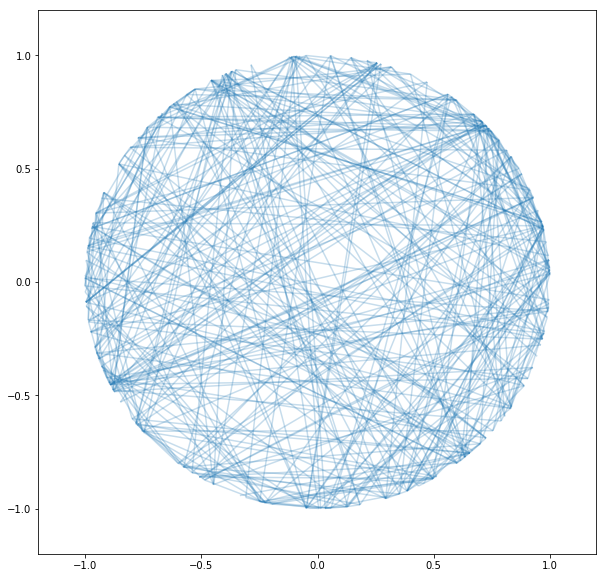

<Figure size 432x288 with 0 Axes>

In [76]:
def show_mat(mat):
    """Plot connection mat."""
    rows, cols = mat.nonzero()
    all_num = np.unique(rows+cols)
    print('num connections:', len(all_num))
    
    lines = [[(np.cos(r),np.sin(r)), (np.cos(c),np.sin(c))] for r, c in zip(rows, cols)]
    lc = collections.LineCollection(lines, alpha=0.25)
    fig, ax = plt.subplots()
    fig.set_size_inches(10,10)
    
    ax.add_collection(lc)
    ax.autoscale()
    ax.margins(0.1)
    
    plt.show()
    plt.clf()

show_mat(W.multiply(J))

**Recall in the network model**

In [60]:
def get_degraded_pattern(pattern, valid, spurious):
    """Return degraded pattern for input to simulation to do pattern completion.
    
    Args:
        pattern: (array) pattern to degrade, 0s or 1s, shape=(num_neurons)
        valid: (float) fraction of valid firing neurons
        spurious: (float) fraction of spurious firing neurons
    
    Return:
        deg_pat: (array) degraded pattern, 0s or 1s, shape=(num_neurons)
    """
    print('pattern of len {} with {} fires'.format(len(pattern), sum(pattern)))
    fires = np.nonzero(pattern)[0]
    deg_fires = npr.choice(fires, size=int(valid*len(fires)), replace=False)
    print('deg_fires:', len(deg_fires))

    nonfires = np.where(pattern == 0)[0]
    spur_fires = npr.choice(nonfires, size=int(spurious*len(nonfires)), replace=False)
    print('nonfires:', len(nonfires))
    print('spur_fires:', len(spur_fires))
    
    all_fires = np.concatenate((deg_fires, spur_fires), axis=0)

    deg_pat = np.zeros(shape=(len(pattern),))
    deg_pat[all_fires] = 1
    
    return deg_pat

def simulate(in_pattern, out_pattern, con_mat, syn_mat, g0, g1, cycles=10, pprint=False):
    """Return final matrix of updates.
    
    Args:
        in_pattern: (array) degraded pattern to start
        out_pattern: (array) original pattern to attempt to recall
        con_mat: (matrix) connectivity matrix
        syn_mat: (matrix) synaptic weights matrix
        g0: (float) firing threshold
        g1: (float) inhibition factor
        cycles: (int) num times to run iteration
    
    Return:
        curr_mat: (matrix) end state matrix
    """
    n = len(in_pattern)
    W_J = con_mat.multiply(syn_mat)
    state = sparse.csr_matrix(np.matrix(in_pattern)).T
    all_inter = []
    if pprint:
        print('{:<10} {:<10} {:<10}'.format('steps', 'correl', 'num fires'))
    for i in range(cycles):
        if pprint:
            curr = state.T.toarray()[0]
            print('{:<10} {:<10.2f} {:<10}'.format(i, get_correlation(curr, out_pattern), sum(curr)))
        _inter = W_J.dot(state)
        all_inter.append((_inter, state))
        h = (1/n) * _inter
        condition = h - ( (1/n) * g1 * np.sum(state) )
        state = condition > g0
        state = _inter > 0.
    curr = state.T.toarray()[0]
    return W_J, all_inter, get_correlation(curr, out_pattern)

def get_correlation(p1, p2):
    p1_ = p1 - (sum(p1)/len(p1))
    p2_ = p2 - (sum(p2)/len(p2))
    return 1 - cosine(p1_, p2_)

b_vald = .5  # fraction of valid firing neurons in patterns
b_spur = 0.0001  # fraction of spurious firing neurons in patterns


now = time()
godpat = M[0, :]
badpat = get_degraded_pattern(godpat, b_vald, b_spur)
print('made degraded pattern in', time() - now)
print('\noriginal pattern:', sum(godpat), 'fires')
print('degraded pattern:', sum(badpat), 'fires')
print('correlation', get_correlation(godpat, badpat))

g_0 = 7 * 10**-6
g_0 = 3 / n
print('g_0', g_0)
g_1 = 0.0
W_J, inters, res = simulate(badpat, godpat, W, J, g_0, g_1, pprint=True)
# should see a correlation between original and degraded patterns of 0.71

pattern of len 30000 with 21 fires
deg_fires: 10
nonfires: 29979
spur_fires: 2
made degraded pattern in 0.006128072738647461

original pattern: 21 fires
degraded pattern: 12.0 fires
correlation 0.629758012082
g_0 0.0001
steps      correl     num fires 
0          0.63       12.0      
1          0.69       10        
2          0.62       8         
3          0.65       9         
4          0.62       8         
5          0.65       9         
6          0.69       10        
7          0.69       10        
8          0.69       10        
9          0.69       10        


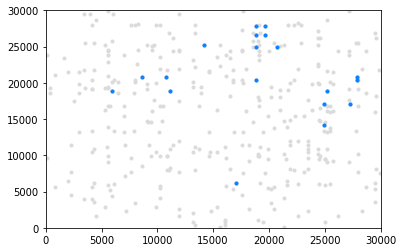

In [47]:
fig, ax = plt.subplots()

ax.set_xlim((0, n))
ax.set_ylim((0, n))

line, = ax.plot([], [], '.', zorder=10, color='#0c81ff')
line_fade, = ax.plot([], [], '.', zorder=5, color='#aad3ff')

rows, cols = W_J.nonzero()
based, = ax.plot(cols, rows, '.', color="#dbdbdb")

def init():
    _inter, state = inters[0]
    align = W_J.multiply(state)
    rows, cols = align.nonzero()
    line.set_data(cols, rows)
    line_fade.set_data(cols, rows)
    return (line,)

#Define the animation function, which is called for each new frame:

def animate(i):
    if i % 2:
        _inter, state = inters[int(i/2)]
        align = W_J.multiply(state)
        rows, cols = align.nonzero()
        line.set_data(cols, rows)
        line_fade.set_data(cols, rows)
    else:
        line.set_data([], [])
    return (line,)

#Compile the animation. Setting blit=True will only re-draw the parts that have changed.

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=20, interval=500, 
                               blit=True)

HTML(anim.to_jshtml())


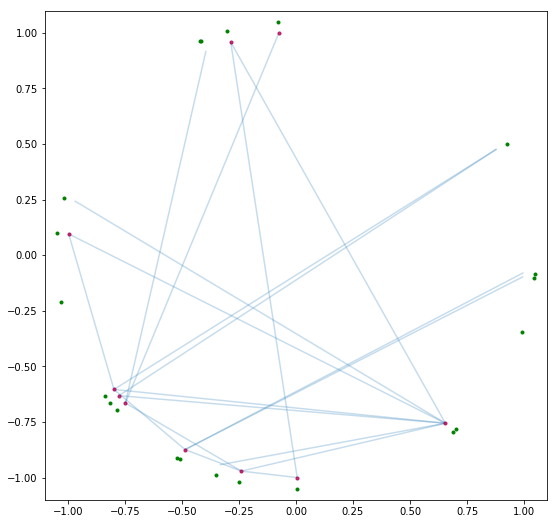

In [74]:
fig, ax = plt.subplots()
fig.set_size_inches(9,9)

ax.set_xlim((0, n))
ax.set_ylim((0, n))

lines = []
lc = collections.LineCollection(lines, alpha=0.25)
ax.add_collection(lc)
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.margins(0.1)
good = godpat.nonzero()
ax.plot(np.cos(good), np.sin(good), 'g.')

def init():
    lines = []
    lc = collections.LineCollection(lines, alpha=0.25)
    ax.clear()
    ax.add_collection(lc)
    ax.set_xlim(-1.1,1.1)
    ax.set_ylim(-1.1,1.1)
    ax.margins(0.1)
    return (lc,)

#Define the animation function, which is called for each new frame:

def animate(i):
    # state is what created _inter
    _inter, state = inters[i]
    align = W_J.multiply(state)
    rows, cols = align.nonzero()
    
    # rows are y (out), and cols are x (in)
    # actually doesn't matter at all
    lines = [[(np.cos(c),np.sin(c)), (np.cos(r),np.sin(r))] for r, c in zip(rows, cols)]
    lc = collections.LineCollection(lines, alpha=0.25)
    ax.clear()
    ax.add_collection(lc)
    
    dots = state.nonzero()[0]
    ax.plot(np.cos(dots), np.sin(dots), 'b.', alpha=0.5)
    
    dots = _inter.nonzero()[0]
    ax.plot(np.cos(dots), np.sin(dots), 'r.', alpha=0.5)
    
    ax.plot(1.05*np.cos(good), 1.05*np.sin(good), 'g.')
    
    ax.set_xlim(-1.1,1.1)
    ax.set_ylim(-1.1,1.1)
    ax.margins(0.1)
    return (lc,)

#Compile the animation. Setting blit=True will only re-draw the parts that have changed.

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=10, interval=500, 
                               blit=True)

HTML(anim.to_jshtml())

In [41]:
3/330000

9.090909090909091e-06